<a href="https://colab.research.google.com/github/echou024/LogisticRegressionOnBreastCancerDataSet/blob/main/LogisticRegressionOnBreastCancerDataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Standard library imports.
import random as rand

# Related third party imports.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Local application/library specific imports.
# import here if you write .py script

In this program, we plot the logistic function and perform logistic regression on a breast cancer data set to detect if the cells are benign or malignant. This data set is described here:

https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin

Each sample is a collection of features that were manually recorded by a physician upon inspecting a sample of cells from fine needle aspiration.  

We could use the `sklearn` built-in `LogisticRegression` class to find the weights for the logistic regression problem.  The `fit` routine in that class has an *optimizer* to select the weights to best match the data.  To understand how that optimizer works, in this problem, we will build a very simple gradient descent optimizer from scratch.  

### Loading and visualizing the Breast Cancer Data:


In [ ]:
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names,na_values='?',header=None)
df = df.dropna()
df.head(6)

,id,thick,size_unif,shape_unif,marg,cell_size,bare,chrom,normal,mit,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2
5,1017122,8,10,10,8,7,10.0,9,7,1,4


Scatter plot of the data labeling the class values with different colors:

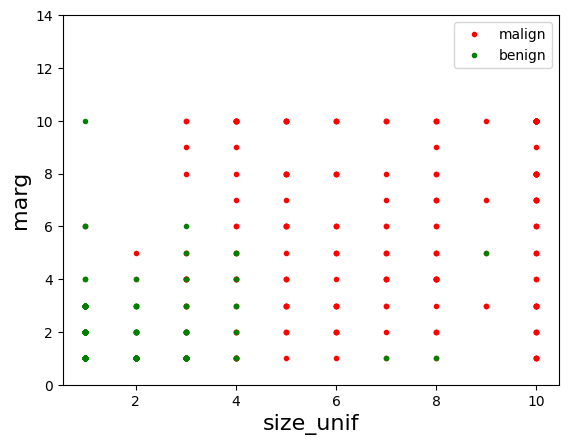

In [ ]:
# Get the response.  Convert to a zero-one indicator
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int)
Iben = (y==0)
Imal = (y==1)

# Get two predictors
xnames =['size_unif','marg']
X = np.array(df[xnames])

# Create the scatter plot
plt.plot(X[Imal,0],X[Imal,1],'r.')
plt.plot(X[Iben,0],X[Iben,1],'g.')
plt.xlabel(xnames[0], fontsize=16)
plt.ylabel(xnames[1], fontsize=16)
plt.ylim(0,14)
plt.legend(['malign','benign'],loc='upper right')

The above plot is not informative, since many of the points are on top of one another.  Thus, we cannot see the relative frequency of points.  

### Logistic function:

We will build a binary classifier using *logistic regression*.  In logistic regression, we do not just output an estimate of the class label.  Instead, we ouput a *probability*, an estimate of how likely the sample is one class or the other.  That is our output is a number from 0 to 1 representing the likelihood:
$$
    P(y = 1|x)
$$
which is our estimate of the probability that the sample is one class (in this case, a malignant sample) based on the features in `x`.  This is sometimes called a *soft classifier*.  

In logistic regression, we assume that likelihood is of the form
$$
    P(y=1|x) = \sigma(z),  \quad z = w(1)x(1) + \cdots + w(d)x(d) + b = \mathbf{w}^T\mathbf{x}+b,  
$$
where $w(1),\ldots,w(d),b$ are the classifier weights and $\sigma(z)$ is the so-called *logistic* function:
$$
    \sigma(z) = \frac{1}{1+e^{-z}}.
$$

To understand the logistic function, suppose $x$ is a scalar and samples $y$ are drawn with $P(y=1|x) = f(w x+b)$ for some $w$ and $b$.  We plot these samples for different $w,b$.

<ipython-input-4-1805887925e7>:21: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,yp,c=yp,edgecolors='none',marker='+')


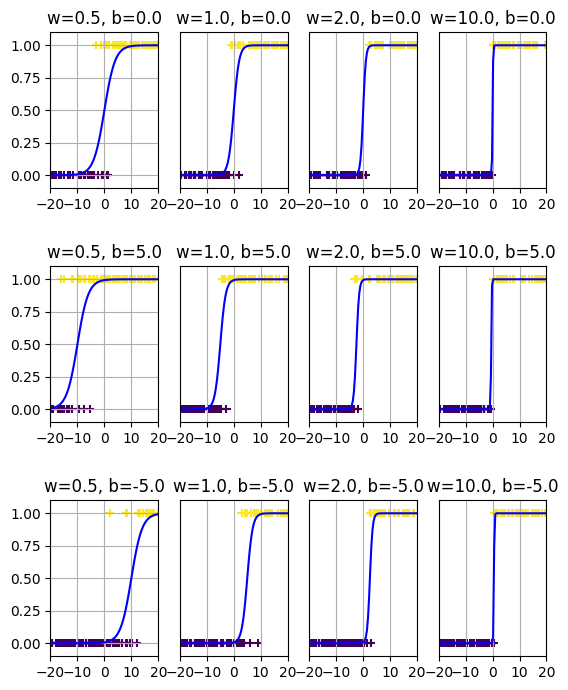

In [ ]:
N = 100
xm = 20
ws = np.array([0.5,1,2,10])
bs = np.array([0, 5, -5])
wplot = ws.size
bplot = bs.size
iplot = 0
for b in bs:
  for w in ws:
    iplot += 1
    x  = np.random.uniform(-xm,xm,N)

    py = 1/(1+np.exp(-w*x-b))

    yp = np.array(np.random.rand(N) < py) # hard label for random points
    xp = np.linspace(-xm,xm,100)
    pyp = 1/(1+np.exp(-w*xp-b)) # soft label (probability) for the points

    plt.subplot(bplot,wplot,iplot)

    plt.scatter(x,yp,c=yp,edgecolors='none',marker='+')
    plt.plot(xp,pyp,'b-')
    plt.axis([-xm,xm,-0.1,1.1])
    plt.grid()
    if ((iplot%4)!=1):
        plt.yticks([])
    plt.xticks([-20,-10,0,10,20])
    plt.title('w={0:.1f}, b={1:.1f}'.format(w,b))

    plt.subplots_adjust(top=1.5, bottom=0.2, hspace=0.5, wspace=0.2)

We see that $\sigma(wx+b)$ represents the probability that $y=1$.  The function $\sigma(wx) > 0.5$ for $x>0$ meaning the samples are more likely to be $y=1$.  Similarly, for $x<0$, the samples are more likely to be $y=0$.  The scaling $w$ determines how fast that transition is and $b$ influences the transition point.  

###Fitting the Logistic Model on Two Variables using Library Implementation:

We will fit the logistic model on the two variables `size_unif` and `marg` that we were looking at earlier.

In [ ]:
# Create a list named xnames that contains 2 elements: 'size_unif' and 'marg'
xnames = ['size_unif', 'marg']

# Take the two columns from the data stored in df variable and convert it to numpy array. Store the result in variable X.
X = df[xnames].values

# Print the shape of variable X
print(X.shape)

(683, 2)


In [ ]:
# Split into training and test
from sklearn.model_selection import train_test_split

# Split the data into train and test set using the train_test_split function setting test_size=0.30
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.30)

**Logistic regression in scikit-learn:**


In [ ]:
from sklearn import datasets, linear_model, preprocessing

# Create the Logistic Regression model using the library class linear_model.LogisticRegression setting C to 1e5
reg = linear_model.LogisticRegression(C=1e5)

# Fit the training data to the model calling the fit() funtion
reg.fit(Xtr, ytr)

# Print the coefficients and intercept of the decision function learnt. They are stored in coef_ and intercept_ attributes of the model
print("Coefficients:", reg.coef_)
print("Intercept:", reg.intercept_)

# Generate the prediction on the test set by calling the predict() function
yhat = reg.predict(Xts)

# Calculate the mean accuracy and print it like "Accuracy on test data = 0.xxxxxx"
acc = reg.score(Xts, yts)
print("Accuracy on test data = %f" % acc)

Coefficients: [[1.56004107 0.30430867]]
Intercept: [-5.87981318]
Accuracy on test data = 0.926829


###Gradient descent for logistic regression:
The weight vector can be found by minimizing the negative log likelihood over $N$ training samples.  The negative log likelihood is called the *loss* function.  For the logistic regression problem, the loss function simplifies to

$$L(\mathbf{w}) = - \sum_{i=1}^N y_i \log \sigma(\mathbf{w}^T\mathbf{x}_i+b) + (1-y_i)\log [1-\sigma(\mathbf{w}^T\mathbf{x}_i+b)].$$

Gradient can be computed as $$\nabla_\mathbf{w}L = \sum_{i=1}^N(\sigma(\mathbf{w}^T\mathbf{x}_i)-y_i)\mathbf{x}_i ,~~~ \nabla_b L = \sum_{i=1}^N(\sigma(\mathbf{w}^T\mathbf{x}_i)-y_i).$$


We can update $\mathbf{w},b$ at every iteration as  
$$ \mathbf{w} \gets \mathbf{w} - \alpha \nabla_\mathbf{w}L, \\ b \gets b - \alpha \nabla_b L.$$

**Note that we could also append the constant term in $\mathbf{w}$ and append 1 to every $\mathbf{x}_i$ accordingly, but we kept them separate in the expressions above.**



**Gradient descent function implementation:**

We will use this loss function and gradient to implement a gradient descent-based method for logistic regression.

Where `X` is the training data feature(s), `y` is the variable to be predicted, `learning_rate` is the learning rate used ($\alpha$ in the slides), `max_iter` defines the maximum number of iterations that gradient descent is allowed to run, and `tol` is defining the tolerance for convergence.

The return values for the above function are 1) `w` which are the regression parameters, 2) `all_cost` which is an array where each position contains the value of the objective function $L(\mathbf{w})$ for a given iteration, 3) `iters` which counts how many iterations did the algorithm need in order to converge to a solution.

Gradient descent is an iterative algorithm; it keeps updating the variables until a convergence criterion is met. In our case, our convergence criterion is whichever of the following two criteria happens first:

- The maximum number of iterations is met
- The relative improvement in the cost is not greater than the tolerance we have specified.

In [ ]:
# TODO
# Your code for logistic regression via gradient descent goes here

def compute_cost(X, w, y, b):
    # your code for the loss function goes here

    # z = w[0]+w[1]*x[1] + ... + w[d]x[d]
    z = np.dot(X, w) + b

    sigmoid = 1 / (1 + np.exp(-z))

    L = -np.sum(y * np.log(sigmoid) + (1 - y) * np.log(1 - sigmoid))

    return L

def compute_gradient(X, w, y, b):

    z = np.dot(X, w) + b

    sigmoid = 1 / (1 + np.exp(-z))

    gradient_w = np.dot(X.T, (sigmoid - y))

    gradient_b = np.sum(sigmoid - y)

    return gradient_w, gradient_b


def logistic_regression_gd(X,y,learning_rate = 0.00001,max_iter=1000,tol=pow(10,-5)):
    # your code goes here

    #initialize the weight vector w
    # creates a numpy array of zeros with a length equal to the number of features in X
    w = np.zeros(X.shape[1])

    #initializes the bias term for 0
    b = 0

    #initializes an empty list to store the cost (or loss) values computed during each iteration
    all_cost = []

    for iters in range(max_iter):

        #compute the cost with the current weights w and bias b
        cost = compute_cost(X, w, y, b)

        #add cost to list
        all_cost.append(cost)

        #compute the gradient
        grad_w, grad_b = compute_gradient(X, w, y, b)

        #update the weight and the bias term
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b

        #check for convergence:
        if iters > 0 and (np.linalg.norm(grad_w) < tol or np.absolute(all_cost[iters] - all_cost[iters-1])/all_cost[iters-1] <= tol):
            break

    return w, all_cost, iters

### Convergence plots and test accuracy:

After implementing gradient descent for logistic regression, we test that  our algorithm converges to a solution. In order see this, we are going to look at the value of the objective/loss function $L(\mathbf{w})$ as a function of the number of iterations, and ideally, what we would like to see is $L(\mathbf{w})$ drops as we run more iterations, and eventually it stabilizes.

We are going to test two different values for the learning rate:
- 0.001
- 0.00001

while keeping the default values for the max number of iterations and the tolerance.


**Calculate accuracy of your classifier on test data:**

To calculate the accuracy of our classifier on the test data, we create a predict method that provides the label 1 if $\mathbf{w}^T\mathbf{x} + b > 0$ and 0 otherwise.  

In [ ]:
# TODO
# Predict on test samples and measure accuracy
def predict(Xts,w,b):
  # your code goes here
  yhat = []
  for x in Xts:
      z = np.dot(x, w) + b
      if z > 0:
          yhat.append(1)
      else:
          yhat.append(0)
  return yhat

Test accuracy = 0.926829


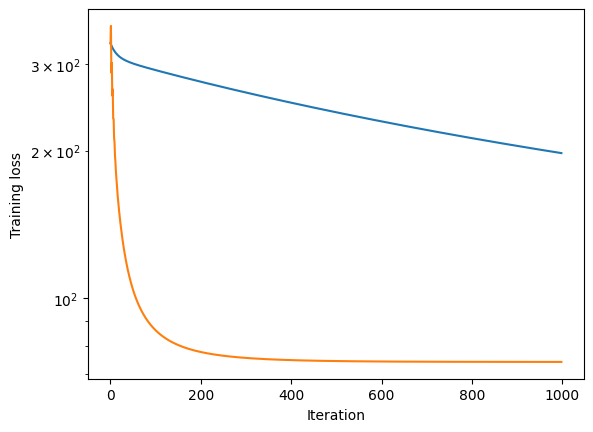

In [ ]:
# TODO
# test gradient descent with step size 0.001
# test gradient descent with step size 0.00001

(w, all_cost,iters) = logistic_regression_gd(Xtr,ytr,learning_rate = 0.00001,max_iter = 1000, tol=pow(10,-6))
plt.semilogy(all_cost[0:iters])
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Training loss')

(w, all_cost,iters) = logistic_regression_gd(Xtr,ytr,learning_rate = 0.001,max_iter = 1000, tol=pow(10,-6))
plt.semilogy(all_cost[0:iters])
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Training loss')

yhat = predict(Xts,w, b)
acc = np.mean(yhat == yts)
print("Test accuracy = %f" % acc)

# complete the rest

# OBSERVATIONS:

1. The model with a learning rate of 0.001 has a higher accuracy than the one with a learning rate of 0.00001.
2. The model with a learning rate of 0.001 has a lower overall training loss as the amount of iterations increase than the model with a learning rate of 0.00001.  



###Print the misclassified data from the test set:


In [ ]:
# Your code for printing the misclassified data
for X, y_true, y_pred in zip(Xts, yts, yhat):
    if y_true != y_pred:
        print(f"Input data: {X} Original label: {y_true} Predicted label: {y_pred}")

Input data: [4 3] Original label: 0 Predicted label: 1
Input data: [3 3] Original label: 0 Predicted label: 1
Input data: [7 1] Original label: 0 Predicted label: 1
Input data: [4 1] Original label: 0 Predicted label: 1
Input data: [1 6] Original label: 1 Predicted label: 0
Input data: [3 2] Original label: 0 Predicted label: 1
Input data: [3 1] Original label: 1 Predicted label: 0
Input data: [3 1] Original label: 1 Predicted label: 0
Input data: [1 3] Original label: 1 Predicted label: 0
Input data: [4 2] Original label: 0 Predicted label: 1
Input data: [2 1] Original label: 1 Predicted label: 0
Input data: [2 4] Original label: 1 Predicted label: 0
Input data: [8 1] Original label: 0 Predicted label: 1
Input data: [2 1] Original label: 1 Predicted label: 0
Input data: [3 1] Original label: 1 Predicted label: 0


Class 0 is showing more misclassification than class 1.
